# MODEL PROJECT 

Imports and set magics:

In [9]:
# We start out by importing packages
import numpy as np
from scipy import optimize
import sympy as sm
import matplotlib.pyplot as plt
from sympy import Symbol
import ipywidgets as widgets
from tabulate import tabulate
from sympy.solvers import solve
sm.init_printing(use_unicode=True)
from IPython.display import display
from modelproject import SolowModel

# autoreload modules when code is run
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of modelproject failed: Traceback (most recent call last):
  File "c:\Users\bjorn\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "c:\Users\bjorn\anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 394, in superreload
    module = reload(module)
  File "c:\Users\bjorn\anaconda3\lib\imp.py", line 314, in reload
    return importlib.reload(module)
  File "c:\Users\bjorn\anaconda3\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "c:\Users\bjorn\OneDrive - University of Copenhagen\4. 

# Part 1: Description of Broydens method 

Boyden’s method is a numerical algorithm used for solving systems of nonlinear equations. It is an iterative method that finds the roots of a set of n nonlinear equations in n variables, where n can be any positive integer. 

It uses the secant method, which uses a finite difference approximation to estimate the Jacobian matrix. Here it uses the current approximation of the Jacobian matrix and the changes in the values of the variables, to compute a new estimate of the Jacobian matrix at the next iteration.

# Part 2: Model description

The Solow-model with human capital can be described by the following equations: 

$K_t =$ Physical capital   

$H_t=$ Human capital 

$L_t =$ Labour

$A_t =$ Teknological level

The overall production function is: 

$Y_t = K_t^{\alpha}H_t^{\varphi}(A_tL_t)^{1-\alpha-\varphi}, \quad 0<\alpha<1, 0<\varphi<1, \alpha+\varphi<1$

The household decides how much to save of physical capital and of human capital.
The savings rate is hereby: 

$S_t = (s_K + s_H)Y_t$
Here $s_H$ denotes the savings of human kapital and $s_K$ denotes the savings of physical capital. 

Accumulation of Human capital: 
$ H_{t+1}=s_HY_t+(1-\delta)H_t, $

Accumulation of capital: 
$K_{t+1}=s_KY_t+(1-\delta)K_t  $ 

Accumulation of Technology: 
$  A_{t+1} = (1+g)A_t $

Accumulation of Labour:
$L_{t+1} = (1+n)L_t $

g denotes the growth rate in technology, n denotes the growthrate in the population and $\delta$ denotes the depreciation in capital

To construct the transition equations we need to define the "tilde" variables: 

$\tilde{k}_{t}= \frac{K_t}{A_tL_t}$

$\tilde{h}_{t}= \frac{H_t}{A_tL_t}$

From here we can construct the two transition eqations used to construct the nullclines: 

For physical capital: 
$\tilde{k}_{t+1} = \frac{1}{(1+n)(1+g)}(s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{k}_{t})$

For human capital: 
$\tilde{h}_{t+1} = \frac{1}{(1+n)(1+g)}(s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}+(1+{\delta})\tilde{h}_{t})$

The two hull-clines are defined as: 

$\tilde{k}_{t+1}-\tilde{k}_{t} = \frac{1}{(1+n)(1+g)}(s_K\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(n+g+{\delta}+ng)\tilde{k}_{t})$

$\tilde{h}_{t+1}-\tilde{h}_{t} = \frac{1}{(1+n)(1+g)}(s_H\tilde{k}_{t}^{\alpha}\tilde{h}_{t}^{\varphi}-(n+g+{\delta}+ng)\tilde{h}_{t})$

# Part 3: Analytical solution

In [2]:
# 1. First we define our symbols:
k_tilde = sm.symbols("ktilde_t")
h_tilde = sm.symbols("htilde_t")
alpha = sm.symbols("alpha")
phi = sm.symbols("phi")
delta = sm.symbols("delta")
g = sm.symbols("g")
n = sm.symbols("n")
sK = sm.symbols("s_K")
sH = sm.symbols("s_H")

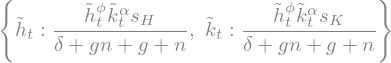

In [3]:
# 2. We define the transition equations:
k_trans = sm.Eq(k_tilde, 1/((1+n)*(1+g)) * (sK * k_tilde**alpha * h_tilde**phi + (1-delta) * k_tilde))
h_trans = sm.Eq(h_tilde, 1/((1+n)*(1+g)) * (sH * k_tilde**alpha * h_tilde**phi + (1-delta) * h_tilde))

# 3. Solving the transition equations
sm.nonlinsolve([k_trans, h_trans], [k_tilde, h_tilde])
ss = sm.solve((k_trans, h_trans),(k_tilde,h_tilde), implicit=True, manual=True)
display(ss)

# Part 4: Numerical solution

We use the broyden algorithm described above in a numerical optimizer to find the numerical solution for our model

In [4]:
# 1. Call class
mp = SolowModel()

# 2. Call function
mp.Num_SS()

Using the Broyden algorithm in out numerical optimizer we get k* = 58.02, h* = 58.02


c:\Users\bjorn\OneDrive - University of Copenhagen\4. semester\projects-2023-pied-piper-4\modelproject\modelproject.py:94: RuntimeWarning: invalid value encountered in double_scalars
  return (h_tilde**par.phi_v * k_tilde**par.alpha_v *par.sK_v +k_tilde*(1-par.delta_v))/((par.g_v+1) * (par.n_v+1)) -k_tilde
c:\Users\bjorn\OneDrive - University of Copenhagen\4. semester\projects-2023-pied-piper-4\modelproject\modelproject.py:108: RuntimeWarning: invalid value encountered in double_scalars
  return (h_tilde**par.phi_v * k_tilde**par.alpha_v *par.sH_v +h_tilde*(1-par.delta_v))/((par.g_v+1) * (par.n_v+1)) -h_tilde
c:\Users\bjorn\anaconda3\lib\site-packages\scipy\optimize\_nonlin.py:912: RuntimeWarning: invalid value encountered in divide
  d = v / vdot(df, v)


# Part 5: Visual solution

To make the visual solution we derive the nullclines from our transition equations and plot them in a phasediagram. The SS for $\tilde{k}_{t}$ & $\tilde{h}_{t}$ is where to the lines cross each other.

In [5]:
# 1. Call class
mp = SolowModel()

# 2. Isolating h_tilde in the transition equation and setting equal to 0 
k_solve = sm.solve(k_trans,h_tilde)[0]
h_solve = sm.solve(h_trans,h_tilde)[0]

# 3. Convert nullclines into python functions
k_null_py = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sK], k_solve)
h_null_py = sm.lambdify([k_tilde, alpha, delta, g, n, phi, sH], h_solve)

# 4. Making a button to reset the value of our sliders to the initial value
reset_button = widgets.Button(description="Reset sliders")

# 5. Defining the button
def reset_sliders(button):
    alpha_slider.value = mp.par.alpha_guess
    phi_slider.value = mp.par.phi_guess
    sK_slider.value = mp.par.sK_guess
    sH_slider.value = mp.par.sH_guess
reset_button.on_click(reset_sliders)
display(reset_button)

# 6. Creating slider values 
alpha_slider = widgets.FloatSlider(
                min=0.1, max=1, step=0.01, value=mp.par.alpha_guess, description="Alpha:")
phi_slider = widgets.FloatSlider(
                min=0.1, max=1, step=0.01, value=mp.par.phi_guess, description="Phi:")
sK_slider = widgets.FloatSlider(
                min=0.1, max=1, step=0.01, value=mp.par.sK_guess, description="sK:")
sH_slider = widgets.FloatSlider(
                min=0.1, max=1, step=0.01, value=mp.par.sH_guess, description="sH:")


# 7. Adding the sliders to our diagram
widgets.interact(mp.phasediagram, 
                alpha_guess=alpha_slider,
                phi_guess=phi_slider,
                sK_guess=sK_slider,
                sH_guess=sH_slider,
                k_null_py=widgets.fixed(k_null_py),
                h_null_py=widgets.fixed(h_null_py),
                )

plt.show()    

Button(description='Reset sliders', style=ButtonStyle())

interactive(children=(FloatSlider(value=0.33, description='Alpha:', max=1.0, min=0.1, step=0.01), FloatSlider(…

The point where the nullclines cross gives us the SS for our model given our chosen parameters.

We see that if using the initial values, we get the same steady state in our phasediagram as in our numerical solution in part 4. Furhermore we notice that the values for $\tilde{k}_{t}$ and $\tilde{h}_{t}$ are the same, approximately 58. This is because the savings rate for both types of capital are the same when we have the initially chosen values. 

The initial values can be chosen by using the "Reset sliders" button. 

# Part 6: Simulating model with a changeable shock to sK

In [12]:
# 1. Calling class
mp = SolowModel()

# 2. Setting the slider parameters
shock_slider = widgets.FloatSlider(
                min=0.12, max=1, step=0.01, value=0.2, description="sK:",continuous_update=True)

# 3. Defining the slider 
def shock_update(shock):
    mp.sK_shock(shock)
    # Clearing y_growth list to allow for new values
    #y_growth.clear() 
    plt.show()

# 4. Adding the sliders to our diagram
widgets.interact(shock_update, shock=shock_slider)

interactive(children=(FloatSlider(value=0.2, description='sK:', max=1.0, min=0.12, step=0.01), Output()), _dom…

<function __main__.shock_update(shock)>

As can be seen in our simulation the higher the shock to the savings rate the higher the growth in y initially becomes. But as time goes on we see that no matter the size of $s_K$ our model always converges to the same growth path. This is in line with the stylized fact about absolute convergence, that says over time GDP per worker converges to one and the same growth path. 

# Part 7: Extension, simulating solow model with human capital and oil

c:\Users\bjorn\OneDrive - University of Copenhagen\4. semester\projects-2023-pied-piper-4\modelproject\modelproject.py:296: RuntimeWarning: divide by zero encountered in log
  
c:\Users\bjorn\OneDrive - University of Copenhagen\4. semester\projects-2023-pied-piper-4\modelproject\modelproject.py:296: RuntimeWarning: invalid value encountered in double_scalars
  


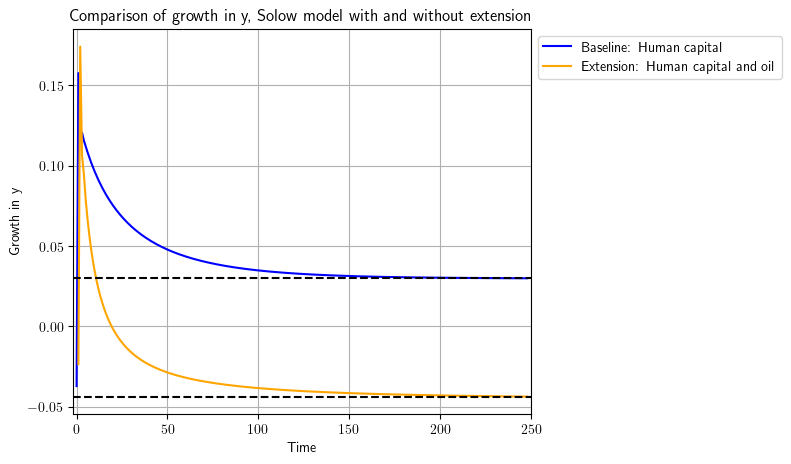

In [16]:
# 1. Calling class
mp = SolowModel()

# 2. Calling function
mp.extension()

# Conclusion

In the above diagram we have simulated the Solow model with human capital and the Solow model with human capital and extension, both simulations were done with the same parameter values.

We see that by adding an exhaustable ressource, in this case oil, our model reaches a lower steady state growth rate than it did in our baseline model. The initial growth rate is higher with the exhaustable ressource but quickly falls below our baseline model as the ressource becomes more and more depleated. 
If the economy wants to have a higher steady state growth path it needs a ressource it won't deplete as quickly or it needs to extractionrate $s_E$ whereby it reaches a higher steady state growth path.